# Axon Initial Segment: Using StatsModels to run Ordinary Least Squares and Linear Mixed‐effects Models

#### Overview:

Following EDA in the notebook titled 'AIS multiple models' where we explored the effect of multiple mutations on the AIS length on the same brain region, here we explore if the same mutation (knocking out the _Fmr1_ gene) affects AIS length similarly across multiple brain regions. The data documents parameters such as location of experiment, genetic mutation, age, gender, parent and background strain. The data appears to be from the same brain region.

#### Hypothesis:

Does the same mutation (or Genotype) alter AIS length across different brain regions in a similar manner? What are the contributions of non-genotype factors such as age and parent on AIS length variance? 

#### EDA:

After initial EDA we found that the data had no null values. Columns 'Species', 'Model', 'Strain,' 'Gender' & 'Location' all had only 1 unique value and therefore did not offer any basis for comparison and were dropped.

__Initial findings:__
1. The data does not appear to be normally distributed and does not pass the Pearson's or Kolmogorov-Smirnov Test normality test.
2. The data does fit a log-normal distribution and should be transformed before performing statistical tests that assume normality.
3. Different Brain regions have different mean measurements, which is to be expected as these cells have different shapes, sizes and activity which will all affect AIS length.
4. The same mutation does Not affect all Brain regions equally and appears to have a region specific effect.

#### Statistical modelling:

Next we look at how we can compare WT versus KO values in each brain region without incurring Type I error (false positives) and losing data variance by comparing only means (as would be encountered if we ran multiple T-tests). I compare model p[erformance on log-transformed and non-log transformed data.

1. _Ordinary Least Squares with Type III ANOVA_: Fixed Effetcs only

2. _Generalised Linear Mixed Modelling_: Fixed & Random effects

3. _Tukey's HSD_: For multiple comparisons across Genotype & Brain Region  

#### Conclusion:
The _Fmr1_ knockout mutation differentially affects AIS length across Brain regions, with increased lengths seen in the 'KO' samples in the medial prefrontal cortex layer 5, somatosensory cortex layer 5 and basal amygdala cells while statistically shorter AIS lengths are observed in somatosensory cortex layer 4 cells. These findings could be the iunderlying mechanism of the differences in cellular excitability observed experiemntally in this model.

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel('../Datasets/AIS_fmr1_GLMM.xlsx')
df.head()

,Species,Model,Strain,Brain region,Sample ID,Genotype,Age,Parent,Gender,Location,AIS length
0,R. Nor.,Fmr1,LE,CA1,214,WT,P27,Fmr1/GFP19,M,BLR,20.899
1,R. Nor.,Fmr1,LE,CA1,214,WT,P27,Fmr1/GFP19,M,BLR,28.109
2,R. Nor.,Fmr1,LE,CA1,214,WT,P27,Fmr1/GFP19,M,BLR,25.490
3,R. Nor.,Fmr1,LE,CA1,214,WT,P27,Fmr1/GFP19,M,BLR,30.017
4,R. Nor.,Fmr1,LE,CA1,214,WT,P27,Fmr1/GFP19,M,BLR,23.697


In [3]:
print ('Unique values are:\n', df.nunique()) #check number of unique values in each column in order to decide which columns to drop
print ()
print ('Null values are:\n', df.isnull().sum()) #check for null values

Unique values are:
 Species            1
Model              1
Strain             1
Brain region      11
Sample ID         12
Genotype           2
Age                2
Parent             2
Gender             1
Location           1
AIS length      8889
dtype: int64

Null values are:
 Species         0
Model           0
Strain          0
Brain region    0
Sample ID       0
Genotype        0
Age             0
Parent          0
Gender          0
Location        0
AIS length      0
dtype: int64


In [4]:
df.drop(['Species', 'Model', 'Strain', 'Gender', 'Location'], axis=1, inplace = True)
df.head() #columns dropped

,Brain region,Sample ID,Genotype,Age,Parent,AIS length
0,CA1,214,WT,P27,Fmr1/GFP19,20.899
1,CA1,214,WT,P27,Fmr1/GFP19,28.109
2,CA1,214,WT,P27,Fmr1/GFP19,25.490
3,CA1,214,WT,P27,Fmr1/GFP19,30.017
4,CA1,214,WT,P27,Fmr1/GFP19,23.697


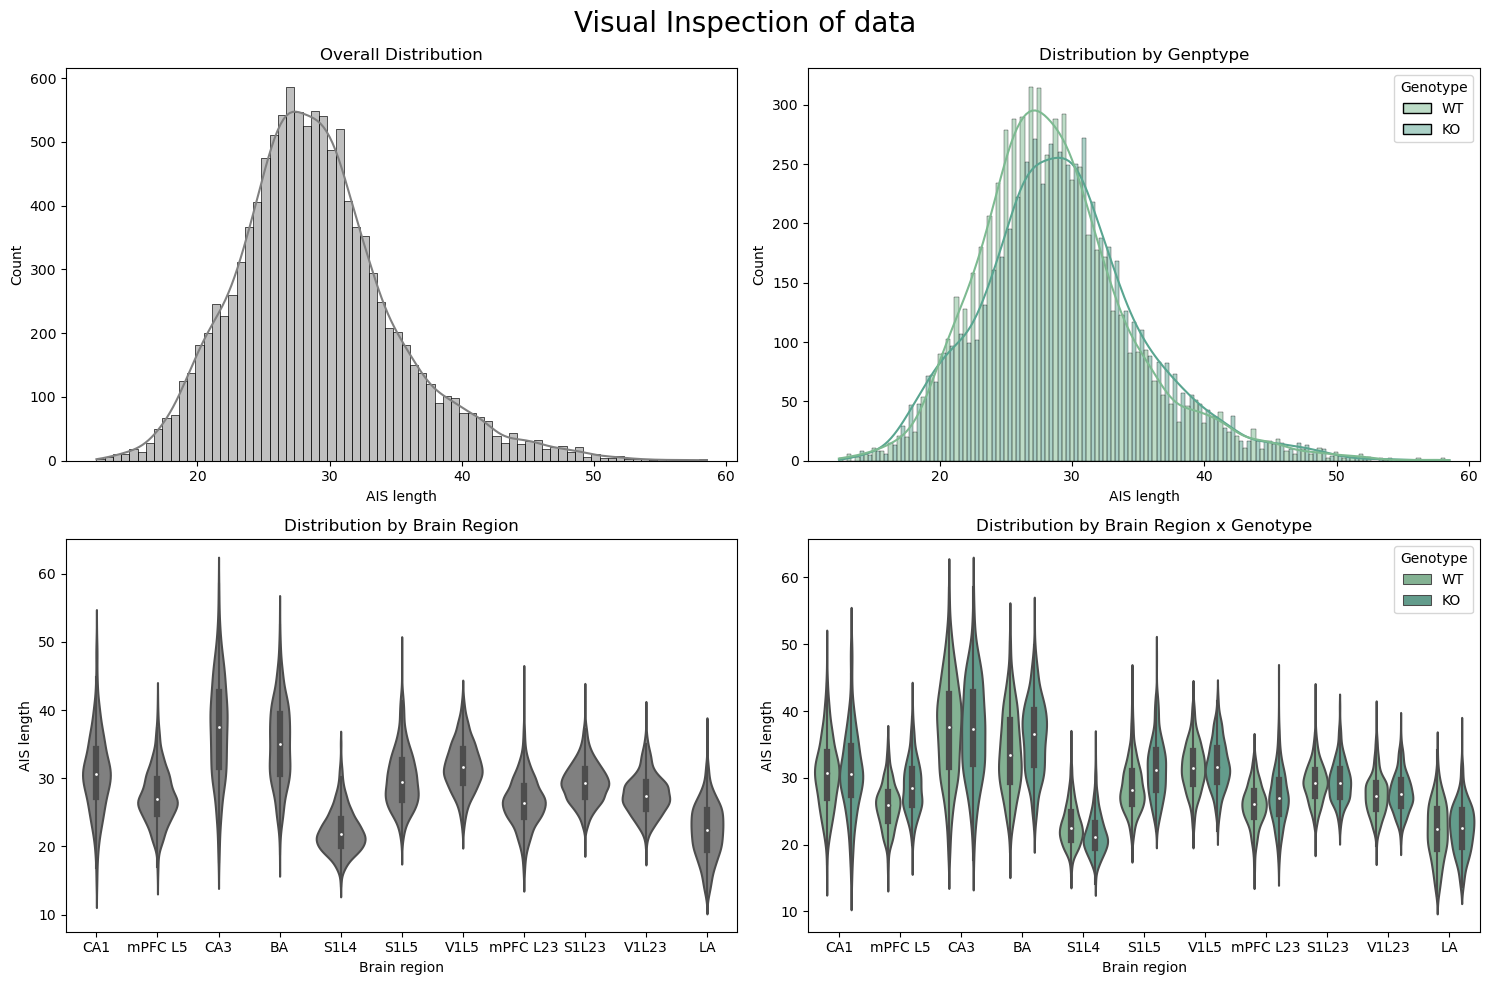

In [5]:
sns.set_palette("crest")

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Visual Inspection of data', fontsize=20)
sns.histplot(df["AIS length"], kde = True, ax = axs[0,0], color='gray')
axs[0,0].set_title('Overall Distribution')
sns.histplot(ax = axs[0,1], data=df, x="AIS length", hue="Genotype", multiple="dodge",  kde=True)
axs[0,1].set_title('Distribution by Genptype')
sns.violinplot(ax = axs[1,0], data=df, x="Brain region", y="AIS length", color='gray', fill=False)
axs[1,0].set_title('Distribution by Brain Region')
sns.violinplot(ax = axs[1,1], data=df, y='AIS length', x="Brain region", hue='Genotype', orient='v')
axs[1,1].set_title('Distribution by Brain Region x Genotype')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

### Test normal distribution of data using stats.normal test (Pearson's) \& Kolmogorov-Smirnov Test (log-normal distribution)

In [6]:
import scipy.stats as stats

In [7]:
print (stats.normaltest(df['AIS length'], axis=0))
print (stats.kstest(df['AIS length'], 'norm'))

NormaltestResult(statistic=1015.6755529467657, pvalue=2.810968478682094e-221)
KstestResult(statistic=1.0, pvalue=0.0, statistic_location=12.355, statistic_sign=-1)


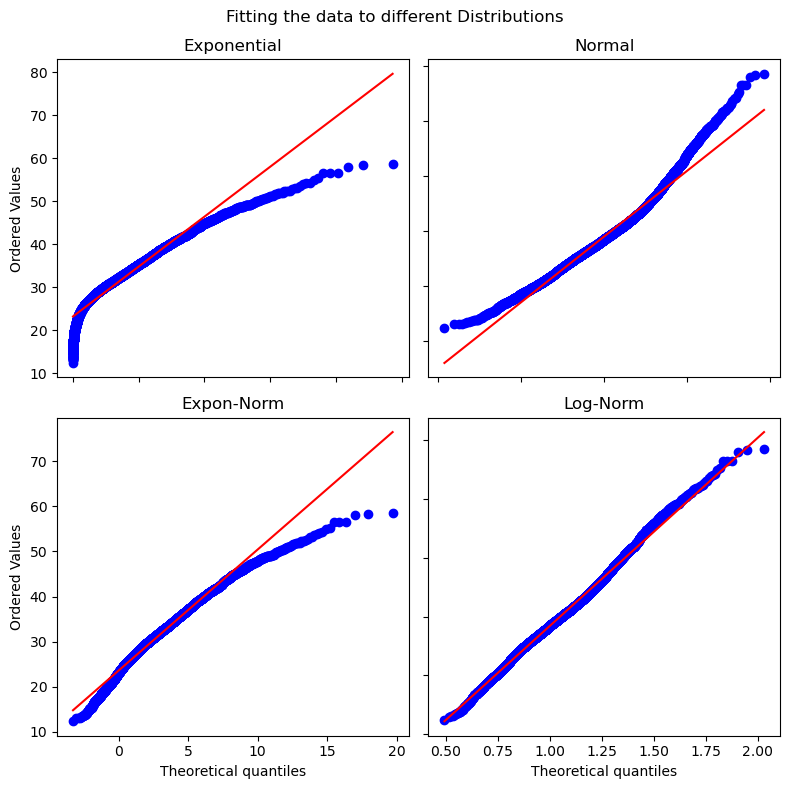

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
fig.suptitle('Fitting the data to different Distributions')
stats.probplot(df['AIS length'], dist='expon', plot=axs[0,0])
axs[0,0].set_title('Exponential')
stats.probplot(df['AIS length'], dist='norm', plot=axs[0,1])
axs[0,1].set_title('Normal')
stats.probplot(df['AIS length'], dist=stats.exponnorm(K=2), plot=axs[1,0])
axs[1,0].set_title('Expon-Norm')
stats.probplot(df['AIS length'], dist=stats.lognorm(s=0.184), plot=axs[1,1])
axs[1,1].set_title('Log-Norm')
for ax in axs.flat:
        ax.set(xlabel='Theoretical quantiles', ylabel='Ordered Values')
        ax.label_outer()
plt.tight_layout()
plt.show()

In [9]:
print(stats.lognorm.fit(df['AIS length']))

(0.18469023863278494, -3.3353488124884727, 31.762678742224907)


In [10]:
from scipy.stats import boxcox

data = boxcox(df['AIS length'], 0) #using box-cox to transform data into log(0)
print(data)
print(stats.normaltest(data, axis=0))
df['log_normal_AIS_length'] = data

[3.03970131 3.33608981 3.23828622 ... 3.26323715 3.0419477  2.87446819]
NormaltestResult(statistic=66.65982131842188, pvalue=3.349683071032869e-15)


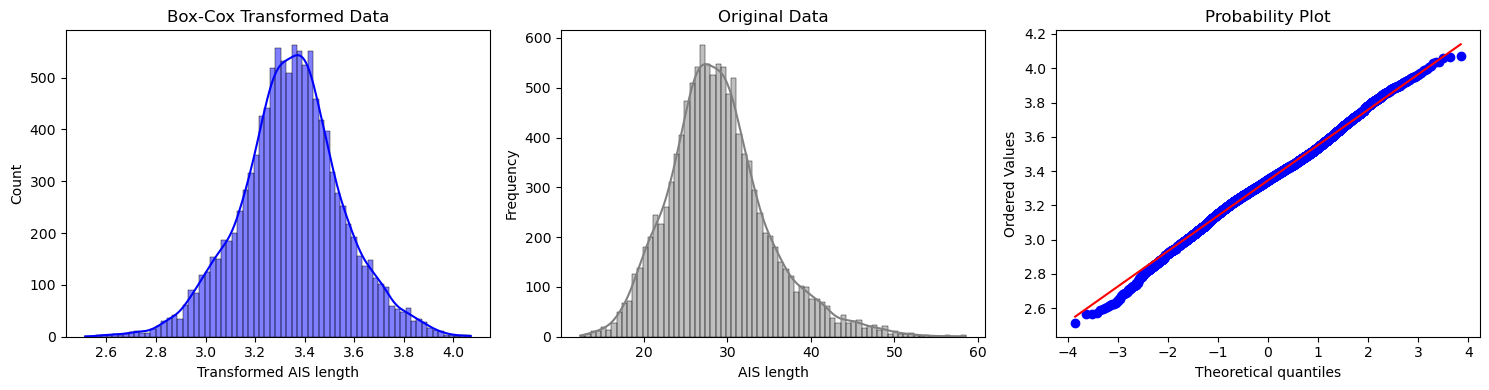

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(15,4))

sns.histplot(data=df, x='log_normal_AIS_length', kde=True, ax=axs[0], color='blue', label='Box-Cox Transformed')
axs[0].set_title('Box-Cox Transformed Data')
axs[0].set_xlabel('Transformed AIS length')
sns.histplot(data=df, x='AIS length', kde=True, ax=axs[1], color='gray', label='Original')
axs[1].set_title('Original Data')
axs[1].set_ylabel('Frequency')
stats.probplot(data, dist='norm', plot=axs[2])

plt.tight_layout()
plt.show()

### Inspect effect of Genotype on AIS lengths by Brain region

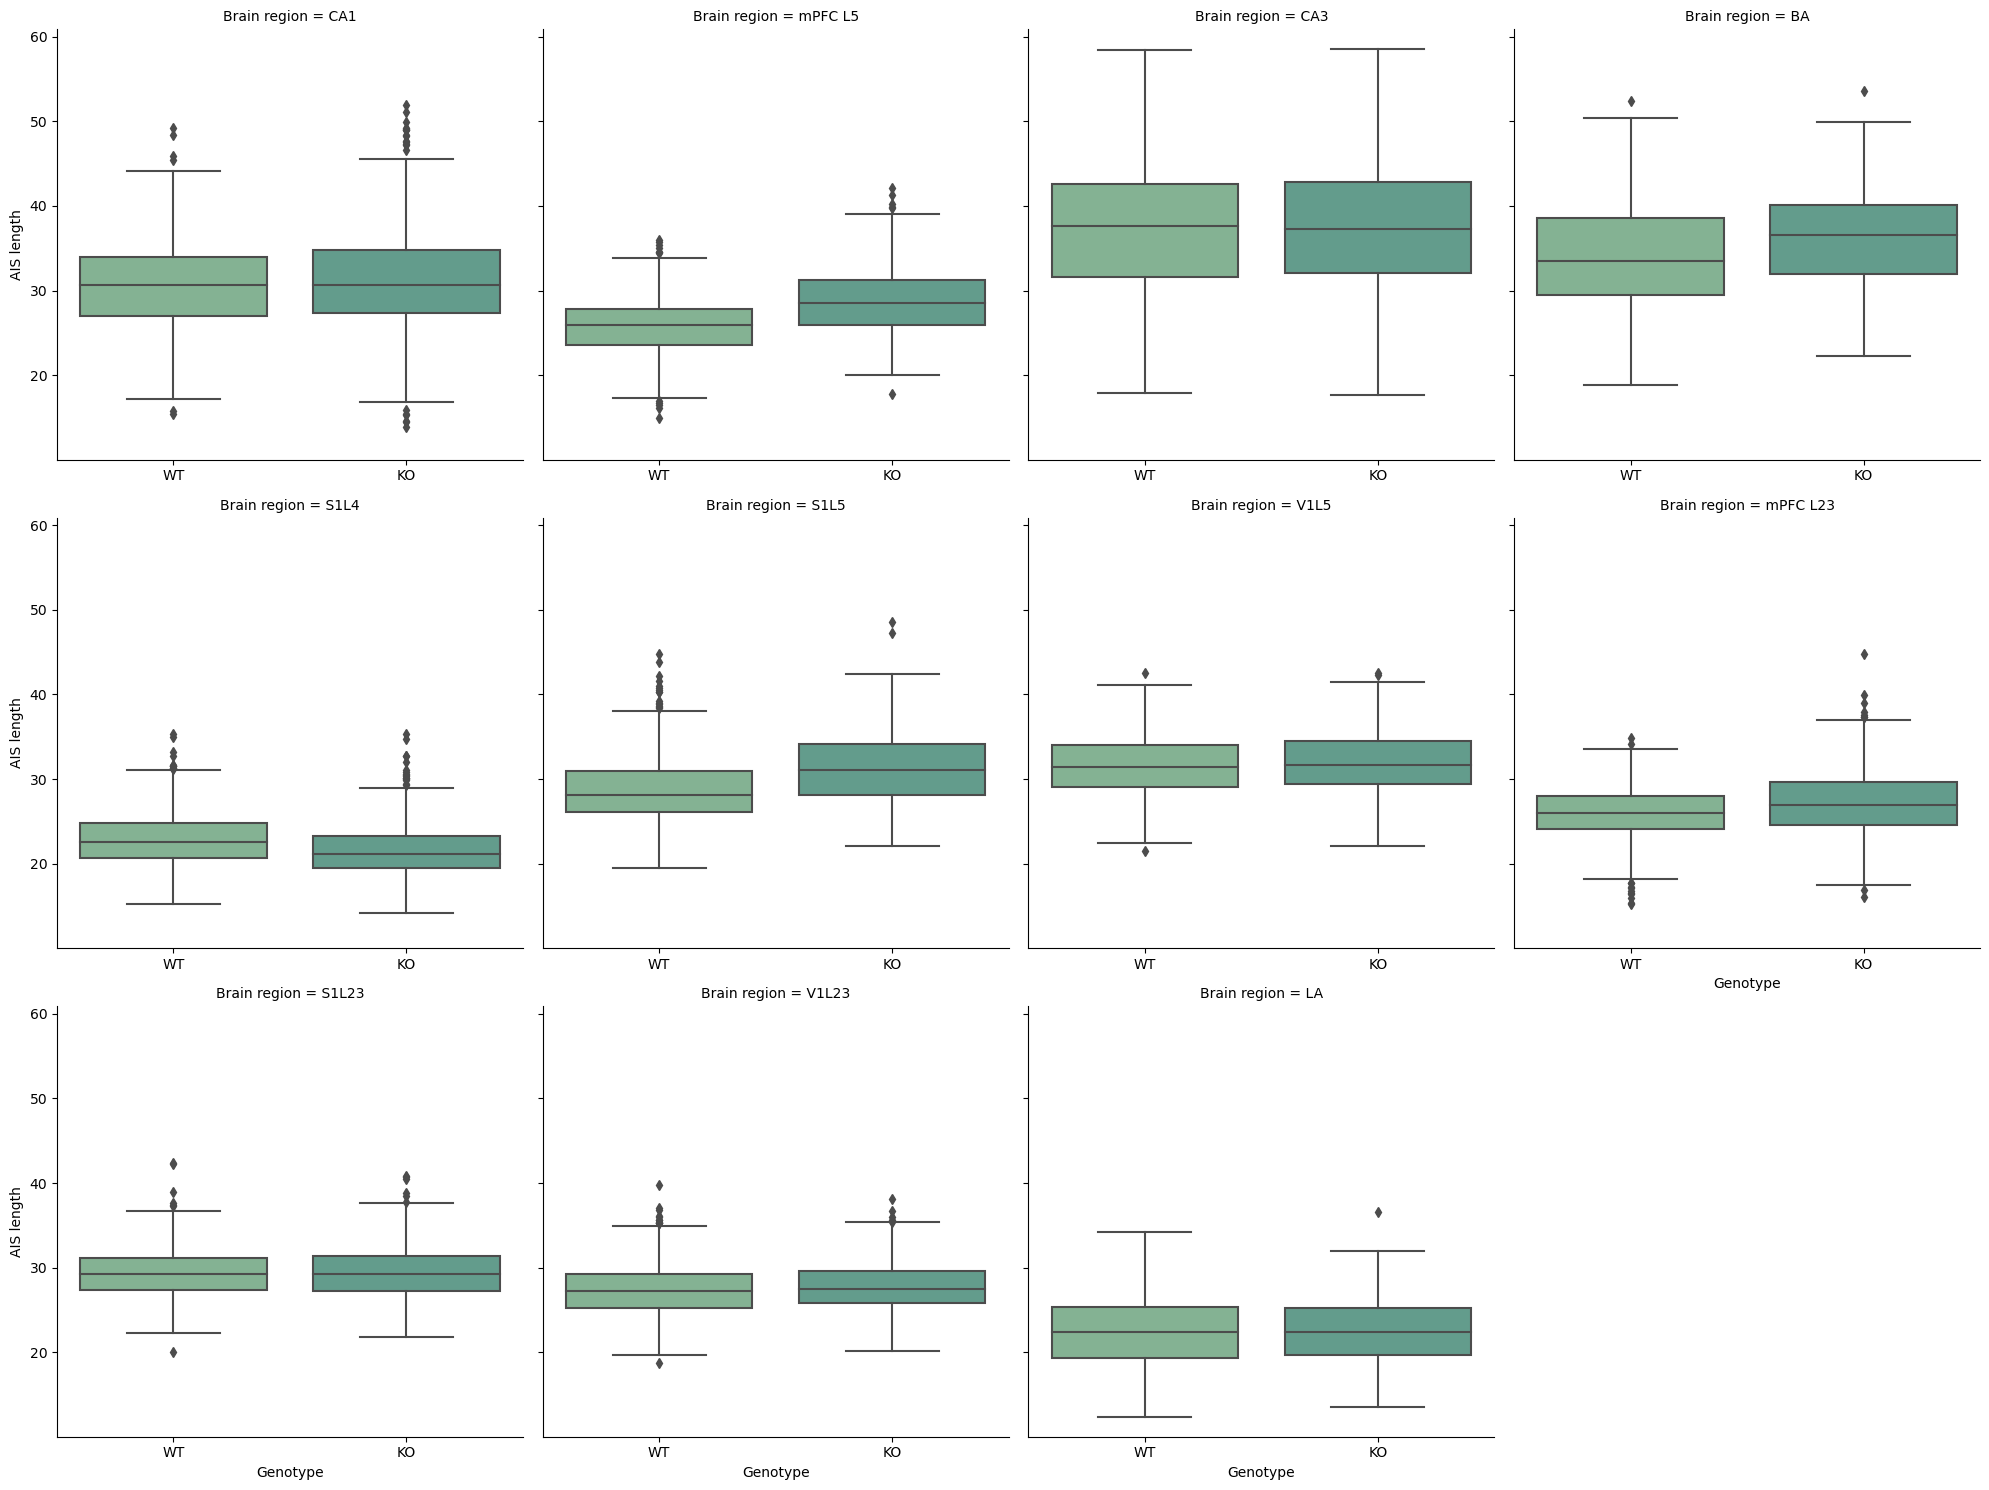

In [12]:
sns.catplot(data=df, x='Genotype', order=('WT', 'KO'), y='AIS length', col='Brain region', col_wrap=4,
            kind='box', sharex=False,)
plt.show()

## Statistical Modelling

In [13]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM
from statsmodels.stats.anova import anova_lm

In [14]:
df.rename(columns={'AIS length': 'AIS_length', 'Brain region': 'Brain_region', 'Sample ID': 'Sample_ID'}, inplace=True)
df.head()

,Brain_region,Sample_ID,Genotype,Age,Parent,AIS_length,log_normal_AIS_length
0,CA1,214,WT,P27,Fmr1/GFP19,20.899,3.039701
1,CA1,214,WT,P27,Fmr1/GFP19,28.109,3.336090
2,CA1,214,WT,P27,Fmr1/GFP19,25.490,3.238286
3,CA1,214,WT,P27,Fmr1/GFP19,30.017,3.401764
4,CA1,214,WT,P27,Fmr1/GFP19,23.697,3.165348


target = df['AIS_length'] OR df['log_normal_AIS_length']
fixed_effects = df[['Genotype', 'Brain_region']]
Subject=df['Sample_ID']
random_effects = df[['Age', 'Parent']] #Note but Parent and Sample_ID are nested variables and therefore will be unable to run in the same model, see SPSS code for dealing with nested variables.

#### Model 1: ANOVA & Ordinary Least Sqaures Model

In [15]:
md_1 = smf.ols(formula='AIS_length ~ Brain_region*Genotype', data=df)
mdf_1 =md_1.fit()
print(mdf_1.summary())
anova_mdf1 = anova_lm(mdf_1, typ=3)
print()
print (f'ANOVA results are \n{anova_mdf1}')

                            OLS Regression Results                            
Dep. Variable:             AIS_length   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.474
Method:                 Least Squares   F-statistic:                     498.2
Date:                Tue, 02 Jul 2024   Prob (F-statistic):               0.00
Time:                        09:34:53   Log-Likelihood:                -33641.
No. Observations:               11608   AIC:                         6.733e+04
Df Residuals:                   11586   BIC:                         6.749e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [16]:
md_2 = smf.ols(formula='log_normal_AIS_length ~ Brain_region*Genotype', data=df)
mdf_2 =md_2.fit()
print(mdf_2.summary())
anova_mdf2 = anova_lm(mdf_2, typ=3)
print()
print (f'ANOVA results are \n{anova_mdf2}')

                              OLS Regression Results                             
Dep. Variable:     log_normal_AIS_length   R-squared:                       0.485
Model:                               OLS   Adj. R-squared:                  0.484
Method:                    Least Squares   F-statistic:                     520.1
Date:                   Tue, 02 Jul 2024   Prob (F-statistic):               0.00
Time:                           09:34:53   Log-Likelihood:                 5670.5
No. Observations:                  11608   AIC:                        -1.130e+04
Df Residuals:                      11586   BIC:                        -1.114e+04
Df Model:                             21                                         
Covariance Type:               nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

#### Model 2: Linear Mixed Effects Model Brain region:Genotype (+ 1 | Sample_ID, Age)

In [17]:
md_3 = smf.mixedlm("AIS_length ~ Genotype*Brain_region", df, groups=df['Sample_ID'], re_formula='Age') #Using not log-transformed data
mdf_3 = md_3.fit(method=["lbfgs"])
print(mdf_3.summary())

                        Mixed Linear Model Regression Results
Model:                       MixedLM          Dependent Variable:          AIS_length 
No. Observations:            11608            Method:                      REML       
No. Groups:                  12               Scale:                       18.8879    
Min. group size:             684              Log-Likelihood:              -33550.1595
Max. group size:             1067             Converged:                   Yes        
Mean group size:             967.3                                                    
--------------------------------------------------------------------------------------
                                         Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
--------------------------------------------------------------------------------------
Intercept                                36.094                                       
Genotype[T.WT]                           -2.065    0.463  -4.461 0.0

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2705: RuntimeWarning: invalid value encountered in sqrt
  sdf[0:self.k_fe, 1] = np.sqrt(np.diag(self.cov_params()[0:self.k_fe]))


In [18]:
md4 = smf.mixedlm("log_normal_AIS_length ~ Genotype*Brain_region", df, groups=df['Sample_ID'], re_formula='Age') #Using log transformed data
mdf_4 = md_4.fit(method=["lbfgs"])
print(mdf_4.summary())

                        Mixed Linear Model Regression Results
Model:                   MixedLM       Dependent Variable:       log_normal_AIS_length
No. Observations:        11608         Method:                   REML                 
No. Groups:              12            Scale:                    0.0215               
Min. group size:         684           Log-Likelihood:           5698.9375            
Max. group size:         1067          Converged:                Yes                  
Mean group size:         967.3                                                        
--------------------------------------------------------------------------------------
                                        Coef.    Std.Err.     z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------
Intercept                                3.583       0.018 194.513 0.000  3.547  3.619
Genotype[T.WT]                          -0.070       0.026  -2.677 0

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [79]:
from tabulate import tabulate #Using tabulate to create a table summary of all four models

Summary_models = [
    ['OLS', 'Original Data', 6.733e+04, 6.749e+04,  -33641, ''], 
    ['OLS', 'Log-transformed Data', -1.130e+04, -1.114e+04, 5670.5, ''], 
    ['LMM', 'Original Data', '', '', -33550.1595, 18.8879], 
      ['LMM', 'Log-transformed Data', '', '', 5698.9375, 0.0215]
]
 
# create header
head = ['Model', 'Data', 'AIC Score', 'BIC Score', 'Log Likelihood', 'Scale']
 
# display table
print (tabulate(Summary_models, headers=head, tablefmt="fancy_grid")) 

╒═════════╤══════════════════════╤═════════════╤═════════════╤══════════════════╤═════════╕
│ Model   │ Data                 │ AIC Score   │ BIC Score   │   Log Likelihood │ Scale   │
╞═════════╪══════════════════════╪═════════════╪═════════════╪══════════════════╪═════════╡
│ OLS     │ Original Data        │ 67330.0     │ 67490.0     │        -33641    │         │
├─────────┼──────────────────────┼─────────────┼─────────────┼──────────────────┼─────────┤
│ OLS     │ Log-transformed Data │ -11300.0    │ -11140.0    │          5670.5  │         │
├─────────┼──────────────────────┼─────────────┼─────────────┼──────────────────┼─────────┤
│ LMM     │ Original Data        │             │             │        -33550.2  │ 18.8879 │
├─────────┼──────────────────────┼─────────────┼─────────────┼──────────────────┼─────────┤
│ LMM     │ Log-transformed Data │             │             │          5698.94 │ 0.0215  │
╘═════════╧══════════════════════╧═════════════╧═════════════╧══════════════════

#### Multiple Comparisons using Pairwise Tukey's Honest Significant Difference

In [19]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=df['AIS_length'], 
                          groups=df['Brain_region'] + ":" + df['Genotype'], 
                          alpha=0.05)

print(tukey.summary())

      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1      group2   meandiff p-adj   lower    upper   reject
----------------------------------------------------------------
      BA:KO       BA:WT  -2.1749    0.0  -3.3525  -0.9973   True
      BA:KO      CA1:KO  -5.2461    0.0  -6.3329  -4.1592   True
      BA:KO      CA1:WT  -5.4194    0.0  -6.4647  -4.3741   True
      BA:KO      CA3:KO   1.0326 0.1561  -0.1227   2.1878  False
      BA:KO      CA3:WT    1.158 0.0251    0.061    2.255   True
      BA:KO       LA:KO -13.7538    0.0 -14.9873 -12.5204   True
      BA:KO       LA:WT  -13.978    0.0 -15.2059 -12.7501   True
      BA:KO    S1L23:KO  -6.6655    0.0  -7.7165  -5.6145   True
      BA:KO    S1L23:WT  -6.8412    0.0  -7.8952  -5.7872   True
      BA:KO     S1L4:KO -14.5303    0.0 -15.5809 -13.4796   True
      BA:KO     S1L4:WT -13.2445    0.0 -14.2958 -12.1931   True
      BA:KO     S1L5:KO  -4.7535    0.0  -5.8463  -3.6608   True
      BA:KO     S1L5:WT  

         Group1      Group 2  Mean Diff   p-adj   Lower   Upper  Reject
0         BA:KO        BA:WT    -2.1749  0.0000 -3.3525 -0.9973    True
1        CA1:KO       CA1:WT    -0.1733  1.0000 -1.1182  0.7715   False
2        CA3:KO       CA3:WT     0.1254  1.0000 -0.9503  1.2010   False
3         LA:KO        LA:WT    -0.2241  1.0000 -1.5080  1.0597   False
4      S1L23:KO     S1L23:WT    -0.1757  1.0000 -1.0892  0.7377   False
5       S1L4:KO      S1L4:WT     1.2858  0.0001  0.3758  2.1959    True
6       S1L5:KO      S1L5:WT    -2.6116  0.0000 -3.5699 -1.6532    True
7      V1L23:KO     V1L23:WT    -0.3278  0.9997 -1.2394  0.5837   False
8       V1L5:KO      V1L5:WT    -0.3567  0.9989 -1.2682  0.5549   False
9   mPFC L23:KO  mPFC L23:WT    -1.1310  0.0012 -2.0284 -0.2336    True
10   mPFC L5:KO   mPFC L5:WT    -2.9734  0.0000 -3.9046 -2.0422    True


<Axes: xlabel='Group 2', ylabel='Group1'>

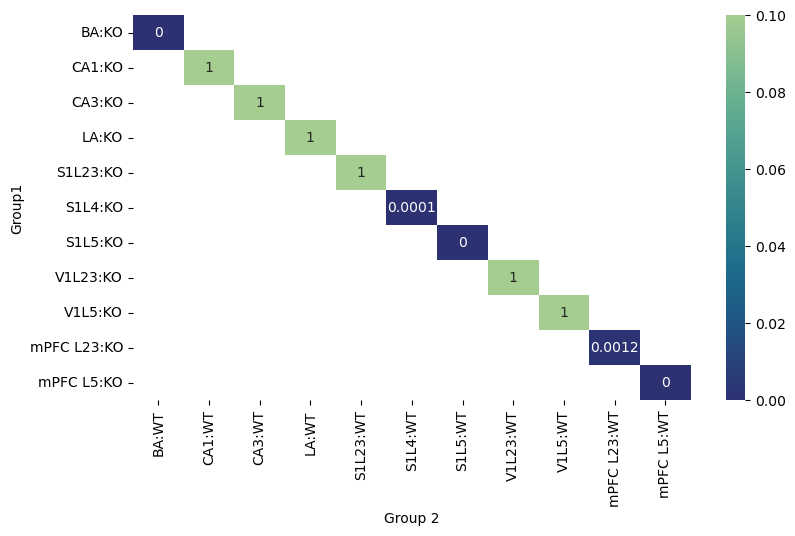

In [64]:
#Filter results for comparison between same brain regions
brain_regions = df['Brain_region'].unique()
results = tukey.summary().data[1:]  # Skip the header
filtered_results = [row for row in results if row[0].split(":")[0] == row[1].split(":")[0]]

filtered_df = pd.DataFrame(filtered_results)
filtered_df.columns=['Group1', 'Group 2', 'Mean Diff', 'p-adj', 'Lower', 'Upper', 'Reject']
print (filtered_df)

fig, ax = plt.subplots(figsize=(9, 5))
filt=filtered_df.pivot(index="Group1", columns="Group 2", values='p-adj')
sns.heatmap(filt, cmap='crest_r', annot=True, cbar=True, vmin=0, vmax=0.1, center=0.05)